In [1]:
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


# Data

In [2]:
muni = pd.read_csv('/Users/julianeoliveira/Documents/Projects/AESOP/AESOP datalake/DTB_BRASIL_MUNICIPIO.csv',sep=';')

muni = muni[['UF', 'Nome_UF', 'Mesorregião Geográfica', 'Nome_Mesorregião',
       'Microrregião Geográfica', 'Nome_Microrregião', 'Município',
       'Código Município Completo', 'Nome_Município']]

muni = muni.assign(co_ibge6 = muni['Código Município Completo'].astype(str).str[0:6])

muni.co_ibge6 = muni.co_ibge6.astype(int)

dta = pd.read_csv('/Users/julianeoliveira/Downloads/union_paths.csv')


hubs = pd.read_csv('/Users/julianeoliveira/Downloads/Reproducibility results_paper2/data/lists_of_hubs.csv')
hubs = hubs[['Nome_UF', 'co_ibge', 'Nome_Município', 'hub_ind_proxi',
       'hub_ind_intermed', 'hub_inter']]

limi = pd.read_csv('/Users/julianeoliveira/Downloads/municipios_limitrofes_ibge.csv')


# Read the Adjacent matrix
link0 = '/Users/julianeoliveira/Downloads/adjacency_matrix_correct.parquet'

matrix = pd.read_parquet(link0, engine='pyarrow')

link_muni_vertice = pd.DataFrame(matrix.columns, columns=['muni'])

df_np = matrix.to_numpy()



In [3]:
df = pd.read_parquet('/Users/julianeoliveira/Downloads/aesop_2025_10_01_mun_withNewEnsIvas.parquet')

df = df[df.epiyear >= 2022]

In [4]:
def get_mname(n):
    
    m = link_muni_vertice.iloc[n]['muni']
    set_muni = muni[muni['Código Município Completo'] == m].reset_index()
    return [set_muni.iloc[0]['Nome_Município'],set_muni.iloc[0]['Nome_UF'],m]
   
def get_mnumber(name):
    muni[muni['Nome_Município'] == name]
    
    co_mu = muni[muni['Nome_Município'] == name].reset_index()['Código Município Completo'][0]
    muni_number = link_muni_vertice[link_muni_vertice['muni'] == co_mu]['muni'].index.tolist()[0]
    return [muni_number, co_mu]

def col_name(dtf,col):
    lst = []
    for value in col:
        muni_name = get_mname(value)[0]
        uf_muni = get_mname(value)[1]
        cod_ibge_muni = get_mname(value)[2]
    
        lst.append([muni_name,uf_muni,cod_ibge_muni])
    
    dta = pd.DataFrame(lst, columns=['muni_name','uf_muni','cod_ibge_muni'])
    
    dtf = dtf.assign(muni_name = dta.muni_name)
    dtf = dtf.assign(uf_muni = dta.uf_muni)
    dtf = dtf.assign(cod_ibge_muni = dta.cod_ibge_muni)
    
    return dtf

In [5]:
def conditional_spread_prob(df, index_city, neighbours, k=1):
    """
    Compute P(neighbour has >=1 warning within k weeks starting at same week as index warning),
    aggregated over all index warnings observed in df.
    
    Parameters
    ----------
    df : DataFrame (rows=cities indexed by code, cols=week labels)
    index_city : city code
    neighbours : list of neighbour city codes
    k : int, window size in weeks (k=0 means same week only; k=1 means same week or next week)
    """
    weeks = list(df.columns)
    n_weeks = len(weeks)
    
    # Find all weeks where index city has a warning (=1)
    index_weeks = [i for i,w in enumerate(weeks) if df.loc[index_city, w] == 1]
    if not index_weeks:
        return None
    
    # For each neighbour, count how many index-week events were followed by at least one warning
    results = []
    for n in neighbours:
        triggered = 0
        total = 0
        for iw in index_weeks:
            # define window [iw, iw + k] inclusive, but not beyond available weeks
            start = iw
            end = min(iw + k, n_weeks - 1)
            total += 1
            # check if neighbour has any 1 in that window
            window_weeks = weeks[start:end+1]
            if df.loc[n, window_weeks].sum() > 0:
                triggered += 1
        prob = triggered / total if total > 0 else np.nan
        results.append({'neighbour': n, 'triggered': triggered, 'total_index_events': total, 'P': prob})
    
    res_df = pd.DataFrame(results).set_index('neighbour')
    # Aggregate across neighbours: probability that *a random neighbour* is triggered
    agg_P = res_df['P'].mean()
    # Probability that at least one neighbour is triggered for each index event
    # compute per index event whether any neighbour had 1 in window, then average
    any_trigger_per_event = []
    for iw in index_weeks:
        start = iw
        end = min(iw + k, n_weeks - 1)
        window_weeks = weeks[start:end+1]
        # check across all neighbours for that index event
        any_trigger = (df.loc[neighbours, window_weeks].sum(axis=0).sum() > 0)
        any_trigger_per_event.append(1 if any_trigger else 0)
    prob_any_neighbour = np.mean(any_trigger_per_event)
    
    return res_df, agg_P, prob_any_neighbour, index_weeks



# Inicio 

In [10]:
lst = ['sigla_uf','co_uf','nm_uf',
     'nm_municipio','co_ibge',  'co_ibge7',
     'epiyear','epiweek','epidemi_cal_start', 'year_week',
     'atend_totais','atend_ivas',
     'sinal_ens_ivas','sinal_otc_ivas','Aviso AESOP',
     'alerta_vizinho', 'aviso_vizinho','sinais_vizinhos',
      'sinal_ens_ivas_new']

dta = dta[['ori_muni_name','ori_uf_name', 'ori_co_ibge', 
           'des_muni_name', 'des_uf_name','des_co_ibge', 
           'path_correct', 'value','muni_1', 'muni_2', 'muni_3','ones']]

In [79]:
lst_results = []

# iterate through origin cities
for city in  df.co_ibge7.unique(): #df[df.nm_uf == 'Ceará'].co_ibge7.unique()
    
    print(f"Processing city: {city}")
    
    # --- Filter health data for the city ---
    set_muni = df[df.co_ibge7 == city].copy()

    # ⚠️ Skip if the origin city never had a warning
    if set_muni['Aviso AESOP'].sum() == 0:
        print(f"  → Skipped (no warning detected for city {city})")
        continue

    # --- Filter connected cities based on mobility data ---
    set_muni_mob = (
        dta[dta.ori_co_ibge == city]
        .groupby(['ori_muni_name', 'ori_uf_name', 'ori_co_ibge', 'muni_1'])[['ones', 'value']]
        .sum()
        .reset_index()
    )

    set_muni_mob = col_name(set_muni_mob, set_muni_mob.muni_1)
    set_muni_mob = set_muni_mob.assign(per=set_muni_mob.ones * 100 / set_muni_mob.ones.sum())

    # --- Build list of destination municipalities (neighbors) ---
    lst_des_muni = list(set_muni_mob.cod_ibge_muni.unique())

    # Add the origin city itself
    lst_des_muni.append(city)

    # Add bordering municipalities from adjacency table `limi`
    border_neigh = list(limi.loc[limi.codigo_ibge_municipio == city, 'codigo_ibge_vizinho'].unique())
    lst_des_muni.extend(border_neigh)

    # Remove duplicates and ensure integers
    lst_des_muni = list(set(map(int, lst_des_muni)))
    
    # ⚠️ Skip if the origin city is isolated in the network, no connections or nbordering cities
    if len(lst_des_muni) <= 1:
        print(f"  → Skipped (no network neighbours for city {city})")
        continue


    # --- Filter data for these cities ---
    data1 = df[df.co_ibge7.isin(lst_des_muni)][['co_ibge7', 'year_week', 'Aviso AESOP']].copy()

    # --- Pivot to wide format (city x week) ---
    table = pd.pivot_table(
        data1,
        values='Aviso AESOP',
        index='co_ibge7',
        columns='year_week',
        aggfunc='sum',
        fill_value=0
    )

    # Define index city and its neighbours
    index_city = city
    neighbours = [c for c in table.index if c != index_city]

    # --- Compute conditional spread probabilities ---
    outputs = {}
    for k in [0, 1, 2, 3, 4, 5]:
        res_df, avg_P, prob_any, index_weeks = conditional_spread_prob(table, index_city, neighbours, k=k)
        outputs[k] = {
            'per_neighbour': res_df,
            'avg_P_neighbour': avg_P,
            'P_any_neighbour': prob_any,
            'index_weeks': index_weeks
        }

    # --- Format results for this origin city ---
    lst_res = []
    for k, out in outputs.items():
        res_data = out['per_neighbour'].reset_index().assign(
            average_neighbour_level_probability=out['avg_P_neighbour'],
            prob_at_least_one_neighbour_triggered=out['P_any_neighbour'],
            k=k,
            origin_city=city
        )
        lst_res.append(res_data)

    final = pd.concat(lst_res, ignore_index=True)
    lst_results.append(final)


Processing city: 1100015
Processing city: 1100023
Processing city: 1100031
Processing city: 1100049
Processing city: 1100056
Processing city: 1100064
Processing city: 1100072
Processing city: 1100080
Processing city: 1100098
Processing city: 1100106
Processing city: 1100114
Processing city: 1100122
Processing city: 1100130
Processing city: 1100148
Processing city: 1100155
Processing city: 1100189
Processing city: 1100205
Processing city: 1100254
Processing city: 1100262
Processing city: 1100288
Processing city: 1100296
Processing city: 1100304
Processing city: 1100320
Processing city: 1100338
Processing city: 1100346
Processing city: 1100379
Processing city: 1100403
Processing city: 1100452
Processing city: 1100502
Processing city: 1100601
Processing city: 1100700
Processing city: 1100809
Processing city: 1100908
Processing city: 1100924
Processing city: 1100940
Processing city: 1101005
Processing city: 1101104
Processing city: 1101203
Processing city: 1101302
Processing city: 1101401


Processing city: 1702554
Processing city: 1702703
Processing city: 1702901
Processing city: 1703008
Processing city: 1703057
Processing city: 1703073
Processing city: 1703107
Processing city: 1703206
Processing city: 1703305
Processing city: 1703602
Processing city: 1703701
Processing city: 1703800
Processing city: 1703826
Processing city: 1703842
Processing city: 1703867
Processing city: 1703883
Processing city: 1703891
Processing city: 1703909
Processing city: 1704105
Processing city: 1704600
Processing city: 1705102
Processing city: 1705508
Processing city: 1705557
Processing city: 1705607
Processing city: 1706001
Processing city: 1706100
Processing city: 1706258
Processing city: 1706506
Processing city: 1707009
Processing city: 1707108
Processing city: 1707207
Processing city: 1707306
Processing city: 1707405
Processing city: 1707553
Processing city: 1707652
Processing city: 1707702
Processing city: 1708205
Processing city: 1708254
Processing city: 1708304
Processing city: 1709005


Processing city: 2112274
Processing city: 2112308
Processing city: 2112407
Processing city: 2112456
Processing city: 2112506
Processing city: 2112605
Processing city: 2112704
Processing city: 2112803
Processing city: 2112852
Processing city: 2112902
Processing city: 2113009
Processing city: 2114007
Processing city: 2200053
Processing city: 2200103
Processing city: 2200202
Processing city: 2200251
Processing city: 2200277
Processing city: 2200301
Processing city: 2200400
Processing city: 2200459
Processing city: 2200509
Processing city: 2200608
Processing city: 2200707
Processing city: 2200806
Processing city: 2200905
Processing city: 2200954
Processing city: 2201002
Processing city: 2201051
Processing city: 2201101
Processing city: 2201150
Processing city: 2201176
Processing city: 2201200
Processing city: 2201309
Processing city: 2201408
Processing city: 2201507
Processing city: 2201556
Processing city: 2201572
Processing city: 2201606
Processing city: 2201705
Processing city: 2201739


Processing city: 2306801
Processing city: 2306900
Processing city: 2307007
Processing city: 2307106
Processing city: 2307205
Processing city: 2307254
Processing city: 2307304
Processing city: 2307403
Processing city: 2307502
Processing city: 2307601
Processing city: 2307635
Processing city: 2307650
Processing city: 2307700
Processing city: 2307809
Processing city: 2307908
Processing city: 2308005
Processing city: 2308104
Processing city: 2308203
Processing city: 2308302
Processing city: 2308351
Processing city: 2308377
Processing city: 2308401
Processing city: 2308500
Processing city: 2308609
Processing city: 2308708
Processing city: 2308807
Processing city: 2308906
Processing city: 2309003
Processing city: 2309102
Processing city: 2309201
Processing city: 2309300
Processing city: 2309409
Processing city: 2309458
Processing city: 2309508
Processing city: 2309607
Processing city: 2309706
Processing city: 2309805
Processing city: 2309904
Processing city: 2310001
Processing city: 2310100


Processing city: 2505238
Processing city: 2505279
Processing city: 2505303
Processing city: 2505352
Processing city: 2505402
Processing city: 2505501
Processing city: 2505600
Processing city: 2505709
Processing city: 2505808
Processing city: 2505907
Processing city: 2506004
Processing city: 2506103
Processing city: 2506202
Processing city: 2506251
Processing city: 2506301
Processing city: 2506400
Processing city: 2506509
Processing city: 2506608
Processing city: 2506707
Processing city: 2506806
Processing city: 2506905
Processing city: 2507002
Processing city: 2507101
Processing city: 2507200
Processing city: 2507309
Processing city: 2507408
Processing city: 2507507
Processing city: 2507606
Processing city: 2507705
Processing city: 2507804
Processing city: 2507903
Processing city: 2508000
Processing city: 2508109
Processing city: 2508208
Processing city: 2508307
Processing city: 2508406
Processing city: 2508505
Processing city: 2508554
Processing city: 2508604
Processing city: 2508703


Processing city: 2615607
Processing city: 2615706
Processing city: 2615805
Processing city: 2615904
Processing city: 2616001
Processing city: 2616100
Processing city: 2616183
Processing city: 2616209
Processing city: 2616308
Processing city: 2616407
Processing city: 2616506
Processing city: 2700102
Processing city: 2700201
Processing city: 2700300
Processing city: 2700409
Processing city: 2700508
Processing city: 2700607
Processing city: 2700706
Processing city: 2700805
Processing city: 2700904
Processing city: 2701001
Processing city: 2701100
Processing city: 2701209
Processing city: 2701308
Processing city: 2701357
Processing city: 2701407
Processing city: 2701506
Processing city: 2701605
Processing city: 2701704
Processing city: 2701803
Processing city: 2701902
Processing city: 2702009
Processing city: 2702108
Processing city: 2702207
Processing city: 2702306
Processing city: 2702355
Processing city: 2702405
Processing city: 2702504
Processing city: 2702553
Processing city: 2702603


Processing city: 2911600
Processing city: 2911659
Processing city: 2911709
Processing city: 2911808
Processing city: 2911857
Processing city: 2911907
Processing city: 2912004
Processing city: 2912103
Processing city: 2912202
Processing city: 2912301
Processing city: 2912400
Processing city: 2912509
Processing city: 2912608
Processing city: 2912707
Processing city: 2912806
Processing city: 2912905
Processing city: 2913002
Processing city: 2913101
Processing city: 2913200
Processing city: 2913309
Processing city: 2913408
Processing city: 2913457
Processing city: 2913507
Processing city: 2913606
Processing city: 2913705
Processing city: 2913804
Processing city: 2913903
Processing city: 2914000
Processing city: 2914109
Processing city: 2914208
Processing city: 2914307
Processing city: 2914406
Processing city: 2914505
Processing city: 2914604
Processing city: 2914653
Processing city: 2914703
Processing city: 2914802
Processing city: 2914901
Processing city: 2915007
Processing city: 2915106


Processing city: 3104700
Processing city: 3104809
Processing city: 3104908
Processing city: 3105004
Processing city: 3105103
Processing city: 3105202
Processing city: 3105301
Processing city: 3105400
Processing city: 3105509
Processing city: 3105608
Processing city: 3105707
Processing city: 3105905
Processing city: 3106002
Processing city: 3106101
  → Skipped (no warning detected for city 3106101)
Processing city: 3106200
Processing city: 3106309
Processing city: 3106408
Processing city: 3106507
Processing city: 3106606
Processing city: 3106655
Processing city: 3106705
Processing city: 3106804
Processing city: 3106903
Processing city: 3107000
Processing city: 3107109
Processing city: 3107208
Processing city: 3107307
Processing city: 3107406
Processing city: 3107505
Processing city: 3107604
Processing city: 3107703
Processing city: 3107802
Processing city: 3107901
Processing city: 3108008
Processing city: 3108107
Processing city: 3108206
Processing city: 3108255
Processing city: 3108305

Processing city: 3133501
Processing city: 3133600
Processing city: 3133709
Processing city: 3133758
Processing city: 3133808
Processing city: 3133907
Processing city: 3134004
Processing city: 3134103
Processing city: 3134202
Processing city: 3134301
Processing city: 3134400
Processing city: 3134509
Processing city: 3134608
Processing city: 3134707
Processing city: 3134806
Processing city: 3134905
Processing city: 3135001
Processing city: 3135050
Processing city: 3135076
Processing city: 3135100
Processing city: 3135209
Processing city: 3135308
Processing city: 3135357
Processing city: 3135407
Processing city: 3135456
Processing city: 3135506
Processing city: 3135605
Processing city: 3135704
Processing city: 3135803
Processing city: 3135902
Processing city: 3136009
Processing city: 3136108
Processing city: 3136207
Processing city: 3136306
Processing city: 3136405
Processing city: 3136504
Processing city: 3136520
Processing city: 3136553
Processing city: 3136579
Processing city: 3136603


Processing city: 3160405
Processing city: 3160454
Processing city: 3160504
Processing city: 3160603
Processing city: 3160702
Processing city: 3160801
Processing city: 3160900
Processing city: 3160959
Processing city: 3161007
Processing city: 3161056
Processing city: 3161106
Processing city: 3161205
Processing city: 3161304
Processing city: 3161403
Processing city: 3161502
Processing city: 3161601
Processing city: 3161650
Processing city: 3161700
Processing city: 3161809
Processing city: 3161908
Processing city: 3162005
Processing city: 3162104
Processing city: 3162203
Processing city: 3162252
Processing city: 3162302
Processing city: 3162401
Processing city: 3162450
Processing city: 3162500
Processing city: 3162559
Processing city: 3162575
Processing city: 3162609
Processing city: 3162658
Processing city: 3162708
Processing city: 3162807
Processing city: 3162906
Processing city: 3162922
Processing city: 3162948
Processing city: 3162955
Processing city: 3163003
Processing city: 3163102


Processing city: 3500402
Processing city: 3500501
Processing city: 3500550
Processing city: 3500600
Processing city: 3500709
Processing city: 3500758
Processing city: 3500808
Processing city: 3500907
Processing city: 3501004
Processing city: 3501103
Processing city: 3501152
Processing city: 3501202
Processing city: 3501301
Processing city: 3501400
Processing city: 3501509
Processing city: 3501608
Processing city: 3501707
Processing city: 3501806
Processing city: 3501905
Processing city: 3502002
Processing city: 3502101
Processing city: 3502200
Processing city: 3502309
Processing city: 3502408
Processing city: 3502606
Processing city: 3502705
Processing city: 3502754
Processing city: 3502804
Processing city: 3502903
Processing city: 3503000
Processing city: 3503109
Processing city: 3503158
Processing city: 3503208
Processing city: 3503307
Processing city: 3503356
Processing city: 3503406
Processing city: 3503505
Processing city: 3503604
Processing city: 3503703
Processing city: 3503802


Processing city: 3529203
Processing city: 3529302
Processing city: 3529401
Processing city: 3529500
Processing city: 3529609
Processing city: 3529658
Processing city: 3529708
Processing city: 3529807
Processing city: 3529906
Processing city: 3530003
Processing city: 3530102
Processing city: 3530201
Processing city: 3530300
Processing city: 3530409
Processing city: 3530508
Processing city: 3530607
Processing city: 3530706
Processing city: 3530805
Processing city: 3530904
Processing city: 3531001
Processing city: 3531100
Processing city: 3531209
Processing city: 3531308
Processing city: 3531407
Processing city: 3531506
Processing city: 3531605
Processing city: 3531704
Processing city: 3531803
Processing city: 3531902
Processing city: 3532009
Processing city: 3532058
Processing city: 3532108
Processing city: 3532157
Processing city: 3532207
Processing city: 3532306
Processing city: 3532405
Processing city: 3532504
Processing city: 3532603
Processing city: 3532702
Processing city: 3532801


Processing city: 4101101
Processing city: 4101150
Processing city: 4101200
Processing city: 4101309
Processing city: 4101408
Processing city: 4101507
Processing city: 4101606
Processing city: 4101655
Processing city: 4101705
Processing city: 4101804
Processing city: 4101853
Processing city: 4101903
Processing city: 4102000
Processing city: 4102109
Processing city: 4102208
Processing city: 4102307
Processing city: 4102406
Processing city: 4102505
Processing city: 4102604
Processing city: 4102703
Processing city: 4102752
Processing city: 4102802
Processing city: 4102901
Processing city: 4103008
Processing city: 4103024
Processing city: 4103040
Processing city: 4103057
Processing city: 4103107
Processing city: 4103156
Processing city: 4103206
Processing city: 4103222
Processing city: 4103305
Processing city: 4103354
Processing city: 4103370
Processing city: 4103404
Processing city: 4103453
Processing city: 4103479
Processing city: 4103503
Processing city: 4103602
Processing city: 4103701


Processing city: 4124400
Processing city: 4124509
Processing city: 4124608
Processing city: 4124707
Processing city: 4124806
Processing city: 4124905
Processing city: 4125001
Processing city: 4125100
Processing city: 4125209
Processing city: 4125308
Processing city: 4125407
Processing city: 4125456
Processing city: 4125506
Processing city: 4125555
Processing city: 4125605
Processing city: 4125704
Processing city: 4125753
Processing city: 4125803
Processing city: 4125902
Processing city: 4126009
Processing city: 4126108
Processing city: 4126207
Processing city: 4126256
Processing city: 4126272
Processing city: 4126306
Processing city: 4126355
Processing city: 4126405
Processing city: 4126504
Processing city: 4126603
Processing city: 4126652
Processing city: 4126678
Processing city: 4126702
Processing city: 4126801
Processing city: 4126900
Processing city: 4127007
Processing city: 4127106
Processing city: 4127205
Processing city: 4127304
Processing city: 4127403
Processing city: 4127502


Processing city: 4217808
Processing city: 4217907
Processing city: 4217956
Processing city: 4218004
Processing city: 4218103
Processing city: 4218202
Processing city: 4218251
Processing city: 4218301
Processing city: 4218350
Processing city: 4218400
Processing city: 4218509
Processing city: 4218608
Processing city: 4218707
Processing city: 4218756
Processing city: 4218806
Processing city: 4218855
Processing city: 4218905
Processing city: 4218954
Processing city: 4219002
Processing city: 4219101
Processing city: 4219150
Processing city: 4219176
Processing city: 4219200
Processing city: 4219309
Processing city: 4219358
Processing city: 4219408
Processing city: 4219507
Processing city: 4219606
Processing city: 4219705
Processing city: 4219853
Processing city: 4220000
Processing city: 4300034
Processing city: 4300059
Processing city: 4300109
Processing city: 4300208
Processing city: 4300307
Processing city: 4300406
Processing city: 4300455
Processing city: 4300471
Processing city: 4300505


Processing city: 4313953
Processing city: 4314001
Processing city: 4314027
Processing city: 4314035
Processing city: 4314050
Processing city: 4314068
Processing city: 4314076
Processing city: 4314100
Processing city: 4314134
Processing city: 4314159
Processing city: 4314175
Processing city: 4314209
Processing city: 4314308
Processing city: 4314407
Processing city: 4314423
Processing city: 4314456
Processing city: 4314464
Processing city: 4314472
Processing city: 4314498
Processing city: 4314506
Processing city: 4314548
Processing city: 4314555
Processing city: 4314605
Processing city: 4314704
Processing city: 4314753
Processing city: 4314779
Processing city: 4314787
Processing city: 4314803
Processing city: 4314902
Processing city: 4315008
Processing city: 4315057
Processing city: 4315073
Processing city: 4315107
Processing city: 4315131
Processing city: 4315149
Processing city: 4315156
Processing city: 4315172
Processing city: 4315206
Processing city: 4315305
Processing city: 4315313


Processing city: 5104500
Processing city: 5104526
Processing city: 5104542
Processing city: 5104559
Processing city: 5104609
Processing city: 5104807
Processing city: 5104906
Processing city: 5105002
Processing city: 5105101
Processing city: 5105150
Processing city: 5105176
Processing city: 5105200
Processing city: 5105234
Processing city: 5105259
Processing city: 5105309
Processing city: 5105507
Processing city: 5105580
Processing city: 5105606
Processing city: 5105622
Processing city: 5105903
Processing city: 5106000
Processing city: 5106109
Processing city: 5106158
Processing city: 5106174
Processing city: 5106182
Processing city: 5106190
Processing city: 5106208
Processing city: 5106216
Processing city: 5106224
Processing city: 5106232
Processing city: 5106240
Processing city: 5106257
Processing city: 5106265
Processing city: 5106273
Processing city: 5106281
Processing city: 5106299
Processing city: 5106307
Processing city: 5106315
Processing city: 5106372
Processing city: 5106422


Processing city: 5221577
Processing city: 5221601
Processing city: 5221700
Processing city: 5221809
Processing city: 5221858
Processing city: 5221908
Processing city: 5222005
Processing city: 5222054
Processing city: 5222203
Processing city: 5222302
Processing city: 5300108


In [80]:
# --- Combine all cities into one DataFrame ---
results_df = pd.concat(lst_results, ignore_index=True)

In [81]:
results_df

,neighbour,triggered,total_index_events,P,average_neighbour_level_probability,prob_at_least_one_neighbour_triggered,k,origin_city
0,1100023,9,40,0.225000,0.328846,0.975,0,1100015
1,1100049,11,40,0.275000,0.328846,0.975,0,1100015
2,1100122,11,40,0.275000,0.328846,0.975,0,1100015
3,1100148,25,40,0.625000,0.328846,0.975,0,1100015
4,1100189,14,40,0.350000,0.328846,0.975,0,1100015
...,...,...,...,...,...,...,...,...
505273,5217609,18,31,0.580645,0.760864,1.000,5,5300108
505274,5218805,26,31,0.838710,0.760864,1.000,5,5300108
505275,5219753,26,31,0.838710,0.760864,1.000,5,5300108
505276,5221601,25,31,0.806452,0.760864,1.000,5,5300108


In [82]:
results_df.to_parquet('/Users/julianeoliveira/Downloads/prob_spread.parquet')

# Probabilidade de espalhamento em uma janela de tempo, ao observar o aviso em uma cidade

In [182]:
def compute_spread_probability(df, index_city, neighbours, start_week=None):
    """
    Compute empirical spread probability from one index city to its neighbours.

    Parameters
    ----------
    df : pd.DataFrame
        Rows = city codes, columns = week identifiers (e.g., '2023-34'), values = 0/1.
    index_city : str or int
        City code of the source (index) city.
    neighbours : list
        List of city codes (neighbours in the network).
    start_week : str, optional
        Week when the index city first had a warning. If None, inferred automatically.
    """

    # Ensure week columns are sorted
    df = df.copy()
    df = df[sorted(df.columns, key=lambda x: int(x.split('-')[1]))]

    # Get index city signal
    signal = df.loc[index_city]

    # Find start week if not given
    if start_week is None:
        start_week = signal[signal == 1].index[0]
    start_idx = list(df.columns).index(start_week)

    # For each neighbour, find delay to first 1 after start_week
    delays = []
    for n in neighbours:
        neigh_signal = df.loc[n].iloc[start_idx + 1:]
        first_1 = np.argmax(neigh_signal.values == 1) if 1 in neigh_signal.values else None
        if first_1 is not None and neigh_signal.values[first_1] == 1:
            delays.append(first_1 + 1)  # +1 because indices start at 0
        else:
            delays.append(np.nan)

    # Build results dataframe
    res = pd.DataFrame({
        'city': neighbours,
        'delay_weeks': delays
    })

    # Empirical cumulative probability of spread
    valid_delays = res['delay_weeks'].dropna().astype(int)
    max_delay = valid_delays.max() if not valid_delays.empty else 0
    weeks = np.arange(1, max_delay + 1)
    prob_cum = [np.mean(valid_delays <= k) for k in weeks]

    # Plot
    plt.figure(figsize=(6, 4))
    plt.plot(weeks, prob_cum, marker='o')
    plt.xlabel("Weeks since index warning")
    plt.ylabel("Cumulative probability of spread")
    plt.title(f"Spread from {index_city}")
    plt.grid(True)
    plt.show()

    return res, pd.DataFrame({'weeks': weeks, 'P(spread)': prob_cum})


In [232]:
#set_muni[set_muni['Aviso AESOP'] == 1]

In [218]:
# seleciona uma semana onde observamos um aviso no município selecionado (origem) e verificamos quando aparece aviso 
# nos destinos

data2 = data1[(data1.year_week >= '2023-25') & (data1.year_week <= '2023-33')][['co_ibge7','year_week','Aviso AESOP']]



In [225]:
data2 = data1[['co_ibge7','year_week','Aviso AESOP']]


In [226]:
table = pd.pivot_table(data2, values='Aviso AESOP', index=['co_ibge7'],
                   columns=['year_week'], aggfunc="sum")


In [233]:
#table

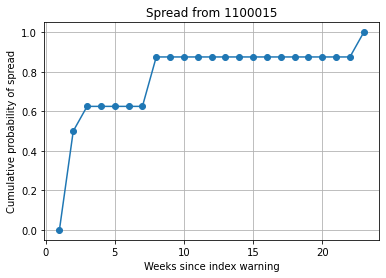

In [228]:
index_city = city
neighbours = list(set_muni_mob.cod_ibge_muni.unique())#[1100023,1100049,1100122,1100189,1100205,1100254,1100288,1100296]

res, prob_curve = compute_spread_probability(table, index_city, neighbours)


In [229]:
print(res)
print(prob_curve)

      city  delay_weeks
0  1100023            8
1  1100049            2
2  1100122            2
3  1100189            3
4  1100205            8
5  1100254            2
6  1100288            2
7  1100296           23
    weeks  P(spread)
0       1      0.000
1       2      0.500
2       3      0.625
3       4      0.625
4       5      0.625
5       6      0.625
6       7      0.625
7       8      0.875
8       9      0.875
9      10      0.875
10     11      0.875
11     12      0.875
12     13      0.875
13     14      0.875
14     15      0.875
15     16      0.875
16     17      0.875
17     18      0.875
18     19      0.875
19     20      0.875
20     21      0.875
21     22      0.875
22     23      1.000


In [230]:
def conditional_spread_prob(df, index_city, neighbours, k=1):
    """
    Compute P(neighbour has >=1 warning within k weeks starting at same week as index warning),
    aggregated over all index warnings observed in df.
    
    Parameters
    ----------
    df : DataFrame (rows=cities indexed by code, cols=week labels)
    index_city : city code
    neighbours : list of neighbour city codes
    k : int, window size in weeks (k=0 means same week only; k=1 means same week or next week)
    """
    weeks = list(df.columns)
    n_weeks = len(weeks)
    
    # Find all weeks where index city has a warning (=1)
    index_weeks = [i for i,w in enumerate(weeks) if df.loc[index_city, w] == 1]
    if not index_weeks:
        return None
    
    # For each neighbour, count how many index-week events were followed by at least one warning
    results = []
    for n in neighbours:
        triggered = 0
        total = 0
        for iw in index_weeks:
            # define window [iw, iw + k] inclusive, but not beyond available weeks
            start = iw
            end = min(iw + k, n_weeks - 1)
            total += 1
            # check if neighbour has any 1 in that window
            window_weeks = weeks[start:end+1]
            if df.loc[n, window_weeks].sum() > 0:
                triggered += 1
        prob = triggered / total if total > 0 else np.nan
        results.append({'neighbour': n, 'triggered': triggered, 'total_index_events': total, 'P': prob})
    
    res_df = pd.DataFrame(results).set_index('neighbour')
    # Aggregate across neighbours: probability that *a random neighbour* is triggered
    agg_P = res_df['P'].mean()
    # Probability that at least one neighbour is triggered for each index event
    # compute per index event whether any neighbour had 1 in window, then average
    any_trigger_per_event = []
    for iw in index_weeks:
        start = iw
        end = min(iw + k, n_weeks - 1)
        window_weeks = weeks[start:end+1]
        # check across all neighbours for that index event
        any_trigger = (df.loc[neighbours, window_weeks].sum(axis=0).sum() > 0)
        any_trigger_per_event.append(1 if any_trigger else 0)
    prob_any_neighbour = np.mean(any_trigger_per_event)
    
    return res_df, agg_P, prob_any_neighbour, index_weeks



In [231]:
# Compute for k = 0 (same week), k = 1 (same or next week), and k = 2
outputs = {}
for k in [0,1,2]:
    res_df, agg_P, prob_any_neighbour, index_weeks = conditional_spread_prob(table, index_city, neighbours, k=k)
    outputs[k] = {'per_neighbour': res_df, 'avg_P_neighbour': agg_P, 'P_any_neighbour': prob_any_neighbour, 'index_weeks': index_weeks}

# Display results
for k, out in outputs.items():
    print(f"\n=== Window k={k} (same week + next {k} weeks) ===")
    print("Index city warning weeks (positions):", out['index_weeks'])
    display(out['per_neighbour'])  # Using display so DataFrame looks nice in the notebook
    print(f"Average neighbour-level probability P = {out['avg_P_neighbour']:.3f}")
    print(f"Probability at least one neighbour triggered given an index event = {out['P_any_neighbour']:.3f}")



=== Window k=0 (same week + next 0 weeks) ===
Index city warning weeks (positions): [35, 36, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 79, 80, 81, 87, 88, 101, 103, 112, 116, 117, 126, 141]


,triggered,total_index_events,P
neighbour,,,
1100023,9,40,0.225
1100049,11,40,0.275
1100122,11,40,0.275
1100189,14,40,0.350
1100205,13,40,0.325
1100254,13,40,0.325
1100288,17,40,0.425
1100296,16,40,0.400


Average neighbour-level probability P = 0.325
Probability at least one neighbour triggered given an index event = 0.925

=== Window k=1 (same week + next 1 weeks) ===
Index city warning weeks (positions): [35, 36, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 79, 80, 81, 87, 88, 101, 103, 112, 116, 117, 126, 141]


,triggered,total_index_events,P
neighbour,,,
1100023,14,40,0.350
1100049,21,40,0.525
1100122,16,40,0.400
1100189,19,40,0.475
1100205,22,40,0.550
1100254,21,40,0.525
1100288,25,40,0.625
1100296,22,40,0.550


Average neighbour-level probability P = 0.500
Probability at least one neighbour triggered given an index event = 0.975

=== Window k=2 (same week + next 2 weeks) ===
Index city warning weeks (positions): [35, 36, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 79, 80, 81, 87, 88, 101, 103, 112, 116, 117, 126, 141]


,triggered,total_index_events,P
neighbour,,,
1100023,20,40,0.500
1100049,25,40,0.625
1100122,22,40,0.550
1100189,23,40,0.575
1100205,27,40,0.675
1100254,27,40,0.675
1100288,28,40,0.700
1100296,26,40,0.650


Average neighbour-level probability P = 0.619
Probability at least one neighbour triggered given an index event = 1.000
